In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from imutils import paths

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
dataset = 'Mask Dataset'
imagePaths = list(paths.list_images(dataset))

In [3]:
data=[]
labels=[]

for i in imagePaths:
    label=i.split(os.path.sep)[-2]
    labels.append(label)
    image=load_img(i,target_size=(224,224))
    image=img_to_array(image)
    image=preprocess_input(image)
    data.append(image)

In [4]:
data=np.array(data,dtype='float32')
labels=np.array(labels)

In [5]:
lb=LabelBinarizer()
labels=lb.fit_transform(labels)
labels=to_categorical(labels)

In [6]:
train_X,test_X,train_Y,test_Y=train_test_split(data,labels,test_size=0.20,stratify=labels,random_state=10)

In [7]:
aug = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,
                       shear_range=0.15,horizontal_flip=True,vertical_flip=True,fill_mode='nearest')

In [8]:
baseModel=MobileNetV2(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

9412608/9406464 [==============================] - 12s 1us/step


In [9]:
print(baseModel.summary())

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [10]:
headModel=baseModel.output
headModel=AveragePooling2D(pool_size=(7,7))(headModel)
headModel=Flatten(name='Flatten')(headModel)
headModel=Dense(128,activation='relu')(headModel)
headModel=Dropout(0.5)(headModel)
headModel=Dense(2,activation='softmax')(headModel)

In [11]:
model=Model(inputs=baseModel.input,outputs=headModel)

In [12]:
for layer in baseModel.layers:
    layer.trainable=False

In [13]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [14]:
learning_rate=0.001
Epochs=20
BS=12

opt = Adam(lr=learning_rate,decay=learning_rate/Epochs)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

D:\Anaconda\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [15]:
H=model.fit(
    aug.flow(train_X,train_Y,batch_size=BS),
    steps_per_epoch=len(train_X)//BS,
    validation_data=(test_X,test_Y),
    validation_steps=len(test_X)//BS,
    epochs=Epochs
)

Epoch 1/20
91/91 [==============================] - 49s 435ms/step - loss: 0.2165 - accuracy: 0.9265 - val_loss: 0.0564 - val_accuracy: 0.9746
Epoch 2/20
91/91 [==============================] - 40s 434ms/step - loss: 0.0651 - accuracy: 0.9798 - val_loss: 0.0555 - val_accuracy: 0.9819
Epoch 3/20
91/91 [==============================] - 38s 412ms/step - loss: 0.0348 - accuracy: 0.9890 - val_loss: 0.0560 - val_accuracy: 0.9783
Epoch 4/20
91/91 [==============================] - 36s 392ms/step - loss: 0.0422 - accuracy: 0.9881 - val_loss: 0.0499 - val_accuracy: 0.9819
Epoch 5/20
91/91 [==============================] - 38s 421ms/step - loss: 0.0385 - accuracy: 0.9890 - val_loss: 0.0410 - val_accuracy: 0.9819
Epoch 6/20
91/91 [==============================] - 40s 440ms/step - loss: 0.0317 - accuracy: 0.9899 - val_loss: 0.0458 - val_accuracy: 0.9819
Epoch 7/20
91/91 [==============================] - 40s 439ms/step - loss: 0.0496 - accuracy: 0.9835 - val_loss: 0.0333 - val_accuracy: 0.9855

In [16]:
model.save('mobilenet_v2.model')

D:\Anaconda\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: mobilenet_v2.model\assets


In [17]:
predict=model.predict(test_X,batch_size=BS)
predict=np.argmax(predict,axis=1)
print(classification_report(test_Y.argmax(axis=1),predict,target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.97      0.99      0.98       138
without_mask       0.99      0.97      0.98       138

    accuracy                           0.98       276
   macro avg       0.98      0.98      0.98       276
weighted avg       0.98      0.98      0.98       276



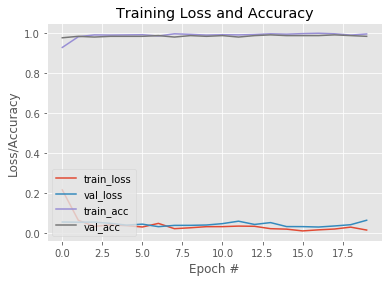

In [21]:
N = Epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('plot_v2.png')